In [1]:
import math
import pandas as pd
import numpy as np
import time
from datetime import datetime
import copy
import os
import random
from typing import Optional, Any, Union, Callable, Tuple
import quantstats
import torch
from torch import nn
from torch import Tensor
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.functional import _in_projection_packed
from torch.nn.modules.linear import NonDynamicallyQuantizableLinear
from torch.nn.init import constant_, xavier_normal_, xavier_uniform_
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
from matplotlib import pyplot
import plotly.offline as pyo
from d2l import torch as d2l

import seaborn as sns
import matplotlib.gridspec as gridspec
from collections import defaultdict
from scipy import stats

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


%matplotlib inline

import matplotlib.pyplot as plt

import re
import pandas as pd
import glob
from tqdm import tqdm, tqdm_notebook
from transformers import BertTokenizer, BertForSequenceClassification
import torch
#pip install torch==1.8.1+cu111 torchvision==0.9.1+cu111 torchaudio===0.8.1 -f https://download.pytorch.org/whl/torch_stable.html 

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
import seaborn as sns
import matplotlib.gridspec as gridspec
from collections import defaultdict
from scipy import stats

def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

class myjoint(sns.JointGrid):
    def __init__(self, x, y, data=None,height=7, ratio=5, space=.2,
                 dropna=True, xlim=None, ylim=None, size=None):
        super(myjoint, self).__init__(x, y, data,height, ratio, space,
                 dropna, xlim, ylim, size)
        plt.close(2)
        # Set up the subplot grid
        self.ax_joint = f.add_subplot(gs[1:, :-1])
        self.ax_marg_x = f.add_subplot(gs[0, :-1], sharex=self.ax_joint)
        self.ax_marg_y = f.add_subplot(gs[1:, -1], sharey=self.ax_joint)

        # Turn off tick visibility for the measure axis on the marginal plots
        plt.setp(self.ax_marg_x.get_xticklabels(), visible=False)
        plt.setp(self.ax_marg_y.get_yticklabels(), visible=False)

In [4]:
df=pd.read_csv("cryptoquant_data/final_combine.csv")
df['date'] = pd.to_datetime(df['date'], format = '%d/%m/%Y')
df

,date,etom_flow_total,etom_transactions_count_flow,etom_flow_mean,mtoe_flow_total,mtoe_transactions_count_flow,mtoe_flow_mean,exchange_addresses_count_inflow,exchange_addresses_count_outflow,exchange_inflow_total,...,taker_sell_volume,taker_buy_ratio,taker_sell_ratio,taker_buy_sell_ratio,exchange_outflow_total,exchange_outflow_top10,exchange_outflow_mean,exchange_outflow_mean_ma7,exchange_netflow_total,miner_netflow_total
0,2016-01-01,239.315793,117,2.045434,245.037136,51,4.804650,17861,8225,23829.684650,...,2.402890e+05,0.497378,0.502622,0.989567,14070.243829,6927.139591,3.288208,3.953170,9759.440821,1693.817533
1,2016-01-02,128.735315,93,1.384251,237.954298,62,3.837973,18755,9181,11099.867349,...,3.758640e+05,0.484778,0.515222,0.940912,12835.223622,5547.606191,2.982855,3.617690,-1735.356273,1303.000408
2,2016-01-03,213.788376,121,1.766846,151.075527,51,2.962265,20945,9515,13295.729379,...,7.306770e+05,0.400210,0.599790,0.667251,13628.660295,7168.301744,2.824593,3.520564,-332.930916,1386.907567
3,2016-01-04,445.146297,141,3.157066,345.013905,65,5.307906,18019,11310,21875.941857,...,4.021300e+05,0.496113,0.503887,0.984572,20912.163154,12059.816788,4.605189,3.638665,963.778703,3541.923439
4,2016-01-05,506.206706,122,4.149235,263.934619,76,3.472824,18473,10344,19891.738077,...,3.320030e+05,0.309386,0.690614,0.447987,20082.407381,11042.671085,4.144120,3.658875,-190.669303,-4772.476726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2087,2021-09-18,21.113824,51,0.413997,416.311514,313,1.330069,16682,17195,15446.717053,...,7.718920e+09,0.505457,0.494543,1.022068,15066.723016,9332.271968,5.903888,8.594778,379.994037,156.954898
2088,2021-09-19,40.032766,66,0.606557,366.559556,309,1.186277,14052,15320,13368.003124,...,8.447522e+09,0.487900,0.512100,0.952744,14704.220166,8309.616751,5.905309,8.678698,-1336.217043,-3.806675
2089,2021-09-20,275.415063,103,2.673933,304.137201,360,0.844826,23068,22064,40580.947165,...,2.214091e+10,0.482775,0.517225,0.933394,35425.347382,17209.380872,11.221206,8.442772,5155.599783,-85.108841
2090,2021-09-21,91.547305,108,0.847660,174.964510,351,0.498474,21263,19524,34547.689220,...,2.298150e+10,0.492107,0.507893,0.968920,32213.383830,17636.679925,10.181221,8.342631,2334.305389,-86.106321


In [5]:
df['log_returns'] = np.log(df['close'] /df['close'].shift(1))

In [6]:
df=df[[ 'date','open',
'high',
'low',
'close',
'volume',
'log_returns']]
df['date'] = pd.to_datetime(df['date'])
df = df.set_index(['date'])
df.index = pd.to_datetime(df.index)
df

<ipython-input-6-f8dff4cf65b3>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,open,high,low,close,volume,log_returns
date,,,,,,
2016-01-01,429.218898,437.133629,426.274285,434.058991,16955.298068,NaN
2016-01-02,435.596409,437.440000,430.000000,433.386840,9651.422099,-0.001550
2016-01-03,435.091003,435.750000,421.746411,430.135274,23129.779711,-0.007531
2016-01-04,429.568659,435.790000,426.970000,433.138279,18885.978814,0.006957
2016-01-05,432.679528,435.503012,428.079667,433.303888,16356.206939,0.000382
...,...,...,...,...,...,...
2021-09-18,47302.757505,48826.141147,47043.103619,48306.880962,81538.471481,0.021006
2021-09-19,48306.715259,48383.176408,46838.240084,47248.778613,71224.829450,-0.022147
2021-09-20,47252.722836,47351.206362,42501.386886,43012.158495,217720.346221,-0.093944


In [7]:
#df_result=pd.read_csv("df_result.csv")
df_result=pd.read_csv("transformer.csv")
df_result

,date,value,prediction,val_above_1,pred_above_1,val_log_returns,pred_log_returns,val_pct_change,pred_pct_change
0,2020-11-12,0.834208,0.791059,0,0,NaN,NaN,NaN,NaN
1,2020-11-13,0.699357,0.779038,0,0,-0.176322,-0.015313,-0.161652,-0.015197
2,2020-11-14,0.578436,0.809928,0,0,-0.189834,0.038886,-0.172903,0.039652
3,2020-11-15,0.934486,0.702080,0,0,0.479669,-0.142897,0.615540,-0.133157
4,2020-11-16,0.550836,0.748576,0,0,-0.528560,0.064125,-0.410547,0.066226
...,...,...,...,...,...,...,...,...,...
309,2021-09-17,0.801553,0.749000,0,0,0.770493,-0.047793,1.160830,-0.046669
310,2021-09-18,0.873800,0.734333,0,0,0.086301,-0.019776,0.090134,-0.019582
311,2021-09-19,0.992394,0.705475,0,0,0.127269,-0.040092,0.135722,-0.039299
312,2021-09-20,0.854799,0.833563,0,0,-0.149254,0.166839,-0.138650,0.181564


In [8]:
df_result['date'] = pd.to_datetime(df_result['date'])
df_result = df_result.set_index(['date'])
df_result.index = pd.to_datetime(df_result.index)
df_result

,value,prediction,val_above_1,pred_above_1,val_log_returns,pred_log_returns,val_pct_change,pred_pct_change
date,,,,,,,,
2020-11-12,0.834208,0.791059,0,0,NaN,NaN,NaN,NaN
2020-11-13,0.699357,0.779038,0,0,-0.176322,-0.015313,-0.161652,-0.015197
2020-11-14,0.578436,0.809928,0,0,-0.189834,0.038886,-0.172903,0.039652
2020-11-15,0.934486,0.702080,0,0,0.479669,-0.142897,0.615540,-0.133157
2020-11-16,0.550836,0.748576,0,0,-0.528560,0.064125,-0.410547,0.066226
...,...,...,...,...,...,...,...,...
2021-09-17,0.801553,0.749000,0,0,0.770493,-0.047793,1.160830,-0.046669
2021-09-18,0.873800,0.734333,0,0,0.086301,-0.019776,0.090134,-0.019582
2021-09-19,0.992394,0.705475,0,0,0.127269,-0.040092,0.135722,-0.039299


In [9]:
comb=df_result.merge(df,left_index=True,right_index=True,how='left')
comb

,value,prediction,val_above_1,pred_above_1,val_log_returns,pred_log_returns,val_pct_change,pred_pct_change,open,high,low,close,volume,log_returns
date,,,,,,,,,,,,,,
2020-11-12,0.834208,0.791059,0,0,NaN,NaN,NaN,NaN,15696.157207,16345.574928,15450.817335,16291.559729,214128.706076,0.037291
2020-11-13,0.699357,0.779038,0,0,-0.176322,-0.015313,-0.161652,-0.015197,16287.671864,16488.409516,15960.005164,16315.084316,158452.757994,0.001443
2020-11-14,0.578436,0.809928,0,0,-0.189834,0.038886,-0.172903,0.039652,16314.480023,16323.969091,15681.559474,16051.868392,121504.869675,-0.016265
2020-11-15,0.934486,0.702080,0,0,0.479669,-0.142897,0.615540,-0.133157,16048.990923,16169.670816,15729.665418,15924.316007,92512.903607,-0.007978
2020-11-16,0.550836,0.748576,0,0,-0.528560,0.064125,-0.410547,0.066226,15962.064327,16886.504265,15817.469185,16715.202910,164451.367393,0.048471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-17,0.801553,0.749000,0,0,0.770493,-0.047793,1.160830,-0.046669,47754.295535,48170.412689,46744.289634,47302.714341,79694.272744,-0.009550
2021-09-18,0.873800,0.734333,0,0,0.086301,-0.019776,0.090134,-0.019582,47302.757505,48826.141147,47043.103619,48306.880962,81538.471481,0.021006
2021-09-19,0.992394,0.705475,0,0,0.127269,-0.040092,0.135722,-0.039299,48306.715259,48383.176408,46838.240084,47248.778613,71224.829450,-0.022147


In [10]:
'''
comb['sent'] = np.where(comb['prediction'] >=1,
                                           comb['prediction'] ,
                                           comb['prediction']*-1)
'''

"\ncomb['sent'] = np.where(comb['prediction'] >=1,\n                                           comb['prediction'] ,\n                                           comb['prediction']*-1)\n"

In [11]:
comb['sent'] = np.where((comb['prediction'] >=1)&(comb['pred_log_returns']>0),
                                           comb['prediction'] * 1 ,
                                           comb['prediction'] * -2)

In [12]:
comb

,value,prediction,val_above_1,pred_above_1,val_log_returns,pred_log_returns,val_pct_change,pred_pct_change,open,high,low,close,volume,log_returns,sent
date,,,,,,,,,,,,,,,
2020-11-12,0.834208,0.791059,0,0,NaN,NaN,NaN,NaN,15696.157207,16345.574928,15450.817335,16291.559729,214128.706076,0.037291,-1.582118
2020-11-13,0.699357,0.779038,0,0,-0.176322,-0.015313,-0.161652,-0.015197,16287.671864,16488.409516,15960.005164,16315.084316,158452.757994,0.001443,-1.558076
2020-11-14,0.578436,0.809928,0,0,-0.189834,0.038886,-0.172903,0.039652,16314.480023,16323.969091,15681.559474,16051.868392,121504.869675,-0.016265,-1.619856
2020-11-15,0.934486,0.702080,0,0,0.479669,-0.142897,0.615540,-0.133157,16048.990923,16169.670816,15729.665418,15924.316007,92512.903607,-0.007978,-1.404161
2020-11-16,0.550836,0.748576,0,0,-0.528560,0.064125,-0.410547,0.066226,15962.064327,16886.504265,15817.469185,16715.202910,164451.367393,0.048471,-1.497153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-17,0.801553,0.749000,0,0,0.770493,-0.047793,1.160830,-0.046669,47754.295535,48170.412689,46744.289634,47302.714341,79694.272744,-0.009550,-1.498000
2021-09-18,0.873800,0.734333,0,0,0.086301,-0.019776,0.090134,-0.019582,47302.757505,48826.141147,47043.103619,48306.880962,81538.471481,0.021006,-1.468666
2021-09-19,0.992394,0.705475,0,0,0.127269,-0.040092,0.135722,-0.039299,48306.715259,48383.176408,46838.240084,47248.778613,71224.829450,-0.022147,-1.410949


In [13]:
comb['log_returns'].describe()

count    314.000000
mean       0.003037
std        0.043736
min       -0.154575
25%       -0.020292
50%        0.002372
75%        0.028311
max        0.178295
Name: log_returns, dtype: float64

In [14]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])

# Import the backtrader platform
import backtrader as bt

In [15]:
# Create a Stratey
class TestStrategy(bt.Strategy):
    params = (
        ('exitbars', 0),
    )

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        self.datasent = self.datas[0].sent
        self.datalogreturn = self.datas[0].log_returns
        
        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        kw_size=0.05#*abs(self.datasent[0])
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
       
            if self.datasent[0] < 1 and self.datalogreturn[0]<0:#2:
            
              # BUY, BUY, BUY!!! (with default parameters)
                
                
                
                self.log('BUY CREATE, %.2f' % self.dataclose[0])
                #kw_size=0.05*self.datasent[0]
                print("current vol: ",self.datasent[0],self.datalogreturn[0])
                print("buy position_size: ",kw_size)
              # Keep track of the created order to avoid a 2nd order
                #self.order = self.buy()
                self.order = self.buy(size=kw_size)
                #print(self.order)
        else:

            # Already in the market ... we might sell
            if len(self) >= (self.bar_executed + self.params.exitbars) and self.datasent[0] > 1 :
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])
                #kw_size=0.05*self.datasent[0]
            
                # Keep track of the created order to avoid a 2nd order
                #self.order = self.sell(size=kw_size)
                self.order=self.close()

In [16]:
class PandasSent(bt.feeds.PandasData):
    
    lines=(('sent'),('log_returns'))
    params=(('sent',-1),('log_returns',-1))

In [17]:
if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(TestStrategy)

    data = PandasSent(dataname=comb)
    
    # Add the Data Feed to Cerebro
    cerebro.adddata(data)
    
    
    # Set our desired cash start
    cerebro.broker.setcash(10000.0)

    # Add a FixedSize sizer according to the stake
    #cerebro.addsizer(bt.sizers.FixedSize, stake=0.02)
    #cerebro.addsizer(kw_sizer, risk=0.05)
   
    # Set the commission - 0.1% ... divide by 100 to remove the %
    cerebro.broker.setcommission(commission=0.001)

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 10000.00
2020-11-12, Close, 16291.56
2020-11-13, Close, 16315.08
2020-11-14, Close, 16051.87
2020-11-14, BUY CREATE, 16051.87
current vol:  -1.6198556 -0.016264844521167162
buy position_size:  0.05
2020-11-15, BUY EXECUTED, Price: 16048.99, Cost: 802.45, Comm 0.80
2020-11-15, Close, 15924.32
2020-11-16, Close, 16715.20
2020-11-17, Close, 17665.35
2020-11-18, Close, 17766.86
2020-11-19, Close, 17814.19
2020-11-20, Close, 18658.64
2020-11-21, Close, 18677.52
2020-11-22, Close, 18398.36
2020-11-23, Close, 18368.57
2020-11-24, Close, 19166.25
2020-11-25, Close, 18719.26
2020-11-26, Close, 17191.38
2020-11-27, Close, 17167.56
2020-11-28, Close, 17739.38
2020-11-29, Close, 18200.33
2020-11-30, Close, 19702.82
2020-12-01, Close, 18791.32
2020-12-02, Close, 19217.31
2020-12-03, Close, 19441.25
2020-12-04, Close, 18655.83
2020-12-05, Close, 19162.30
2020-12-06, Close, 19383.42
2020-12-07, Close, 19182.85
2020-12-08, Close, 18320.28
2020-12-09, Close, 18547.34
2020-12-1

In [18]:
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.rcParams['figure.figsize']=[5, 3]
plt.rcParams['figure.dpi']=150
plt.rcParams['figure.facecolor']='w'
plt.rcParams['figure.edgecolor']='k'

<IPython.core.display.Javascript object>


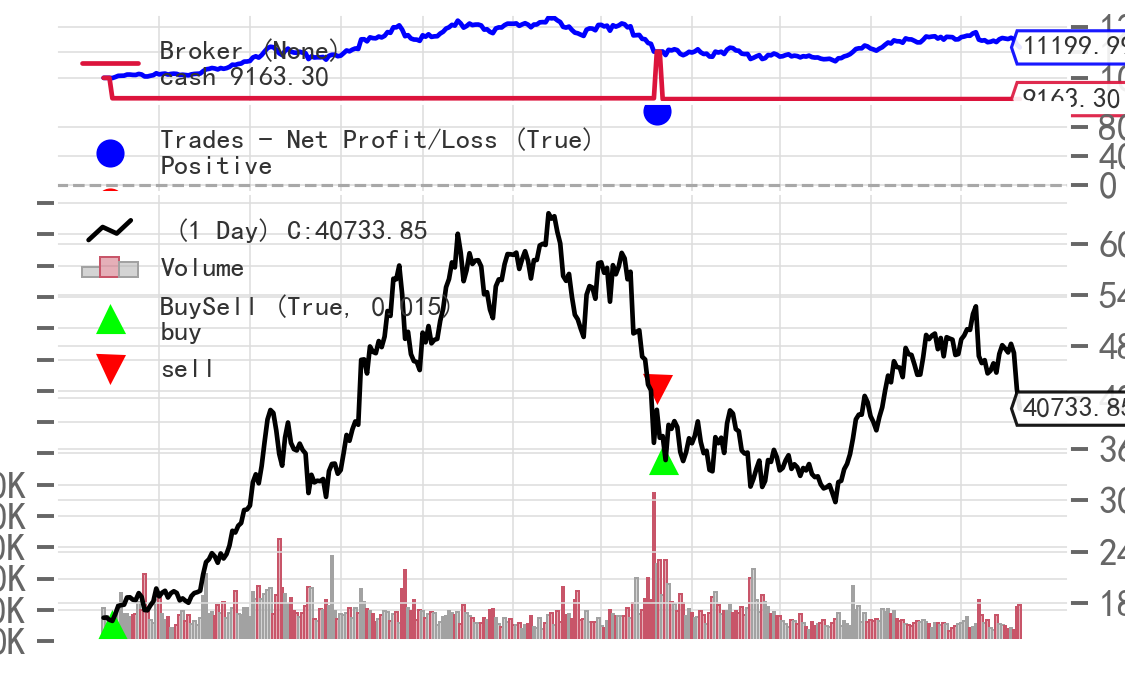

[[<Figure size 750x450 with 4 Axes>]]

In [19]:
#cerebro.plot(style='bar')
cerebro.plot()

In [20]:
comb.to_csv('backtrader_unscaled_buylowsellhigh.csv',index=False)

In [21]:
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='PyFolio')

In [22]:
results = cerebro.run()
strat = results[0]

2020-11-12, Close, 16291.56
2020-11-13, Close, 16315.08
2020-11-14, Close, 16051.87
2020-11-14, BUY CREATE, 16051.87
current vol:  -1.6198556 -0.016264844521167162
buy position_size:  0.05
2020-11-15, BUY EXECUTED, Price: 16048.99, Cost: 802.45, Comm 0.80
2020-11-15, Close, 15924.32
2020-11-16, Close, 16715.20
2020-11-17, Close, 17665.35
2020-11-18, Close, 17766.86
2020-11-19, Close, 17814.19
2020-11-20, Close, 18658.64
2020-11-21, Close, 18677.52
2020-11-22, Close, 18398.36
2020-11-23, Close, 18368.57
2020-11-24, Close, 19166.25
2020-11-25, Close, 18719.26
2020-11-26, Close, 17191.38
2020-11-27, Close, 17167.56
2020-11-28, Close, 17739.38
2020-11-29, Close, 18200.33
2020-11-30, Close, 19702.82
2020-12-01, Close, 18791.32
2020-12-02, Close, 19217.31
2020-12-03, Close, 19441.25
2020-12-04, Close, 18655.83
2020-12-05, Close, 19162.30
2020-12-06, Close, 19383.42
2020-12-07, Close, 19182.85
2020-12-08, Close, 18320.28
2020-12-09, Close, 18547.34
2020-12-10, Close, 18261.48
2020-12-11, Clos

In [23]:
portfolio_stats = strat.analyzers.getbyname('PyFolio')
returns, positions, transactions, gross_lev = portfolio_stats.get_pf_items()
returns.index = returns.index.tz_convert(None)

<IPython.core.display.Javascript object>


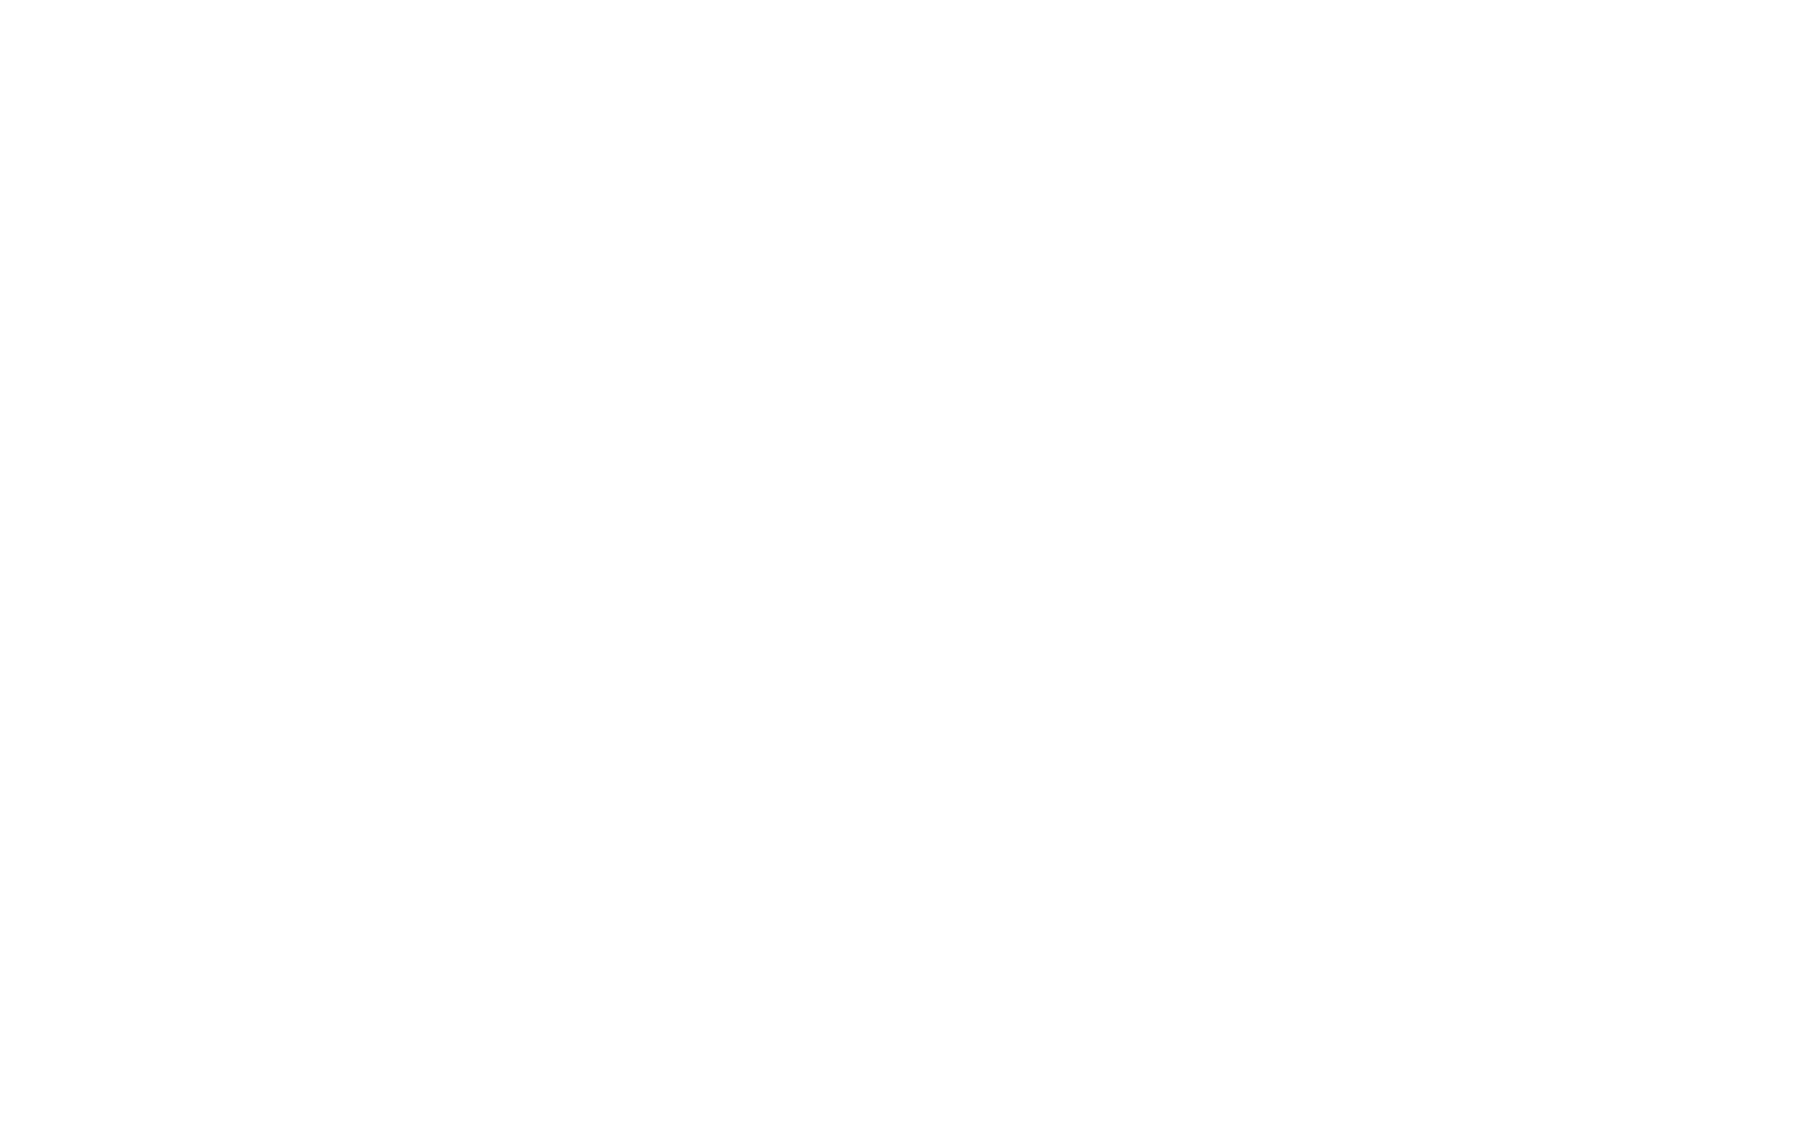

<IPython.core.display.Javascript object>


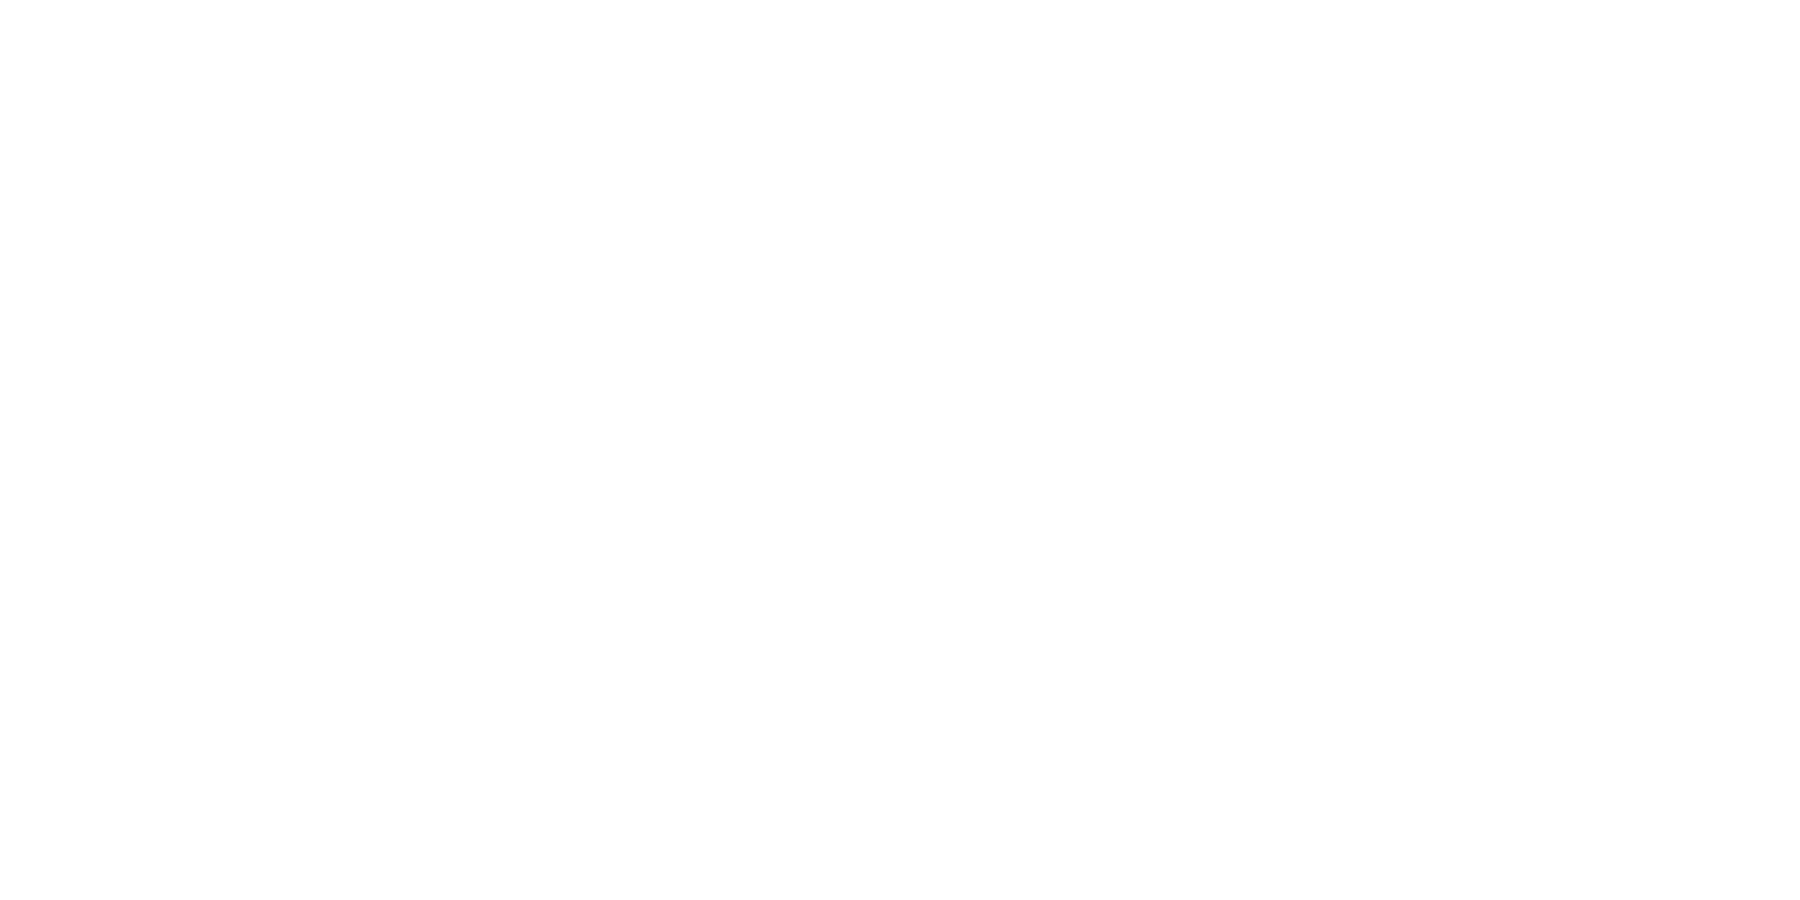

<IPython.core.display.Javascript object>


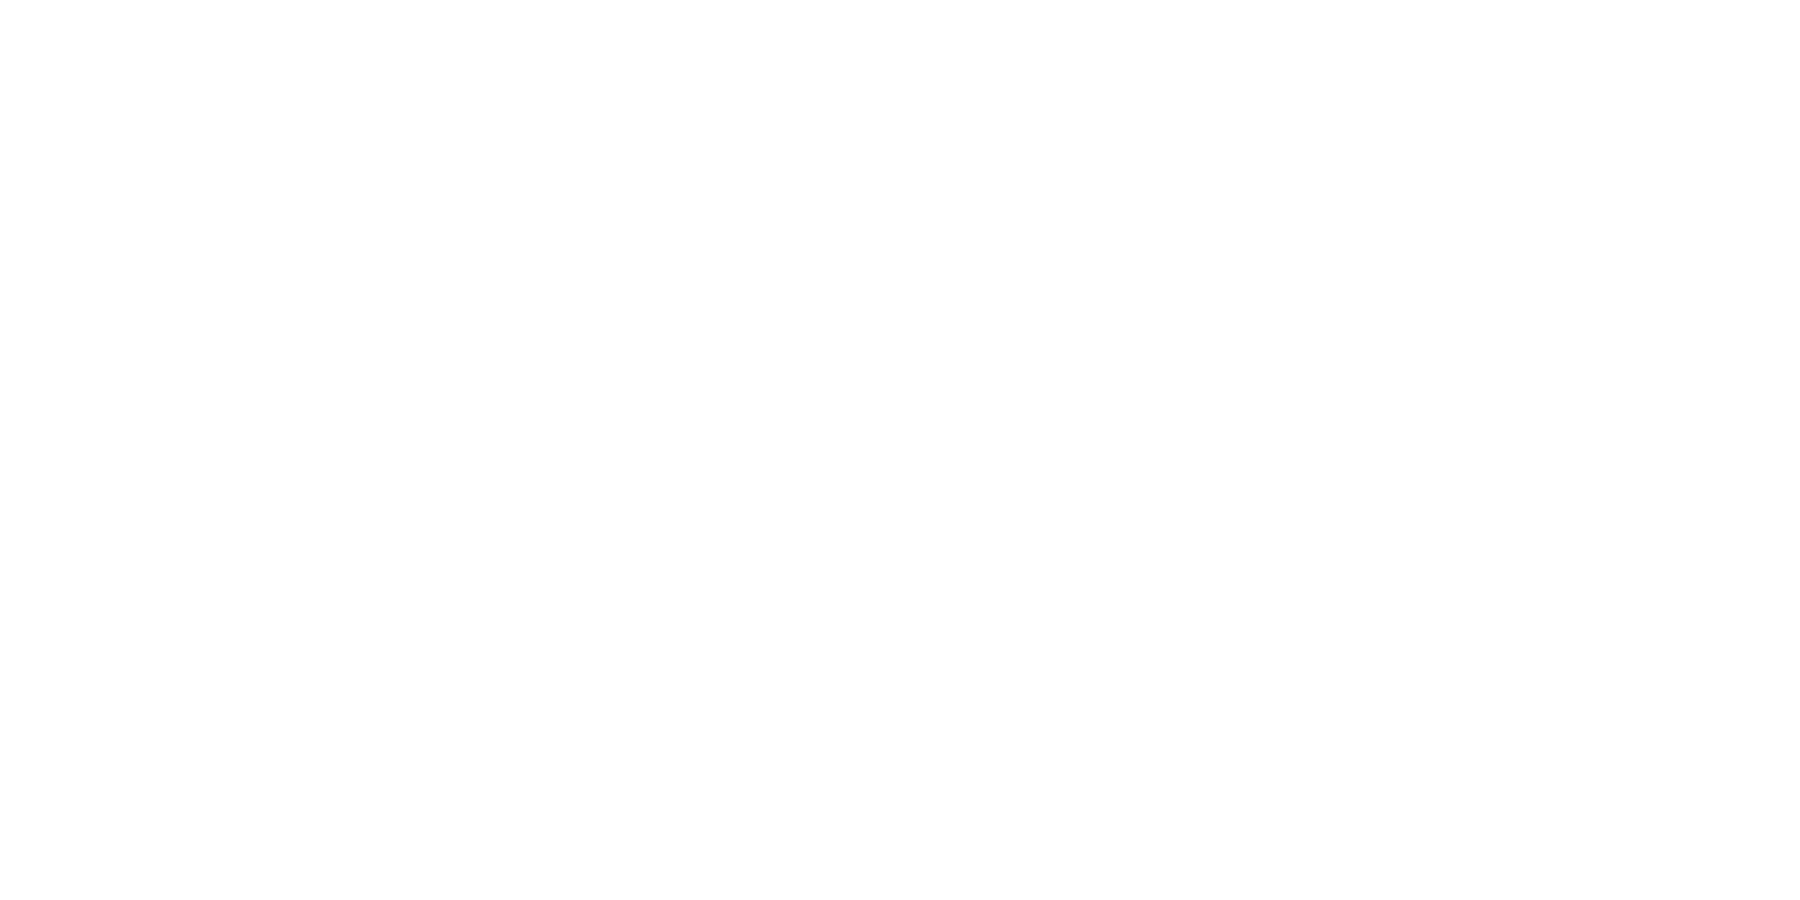

<IPython.core.display.Javascript object>


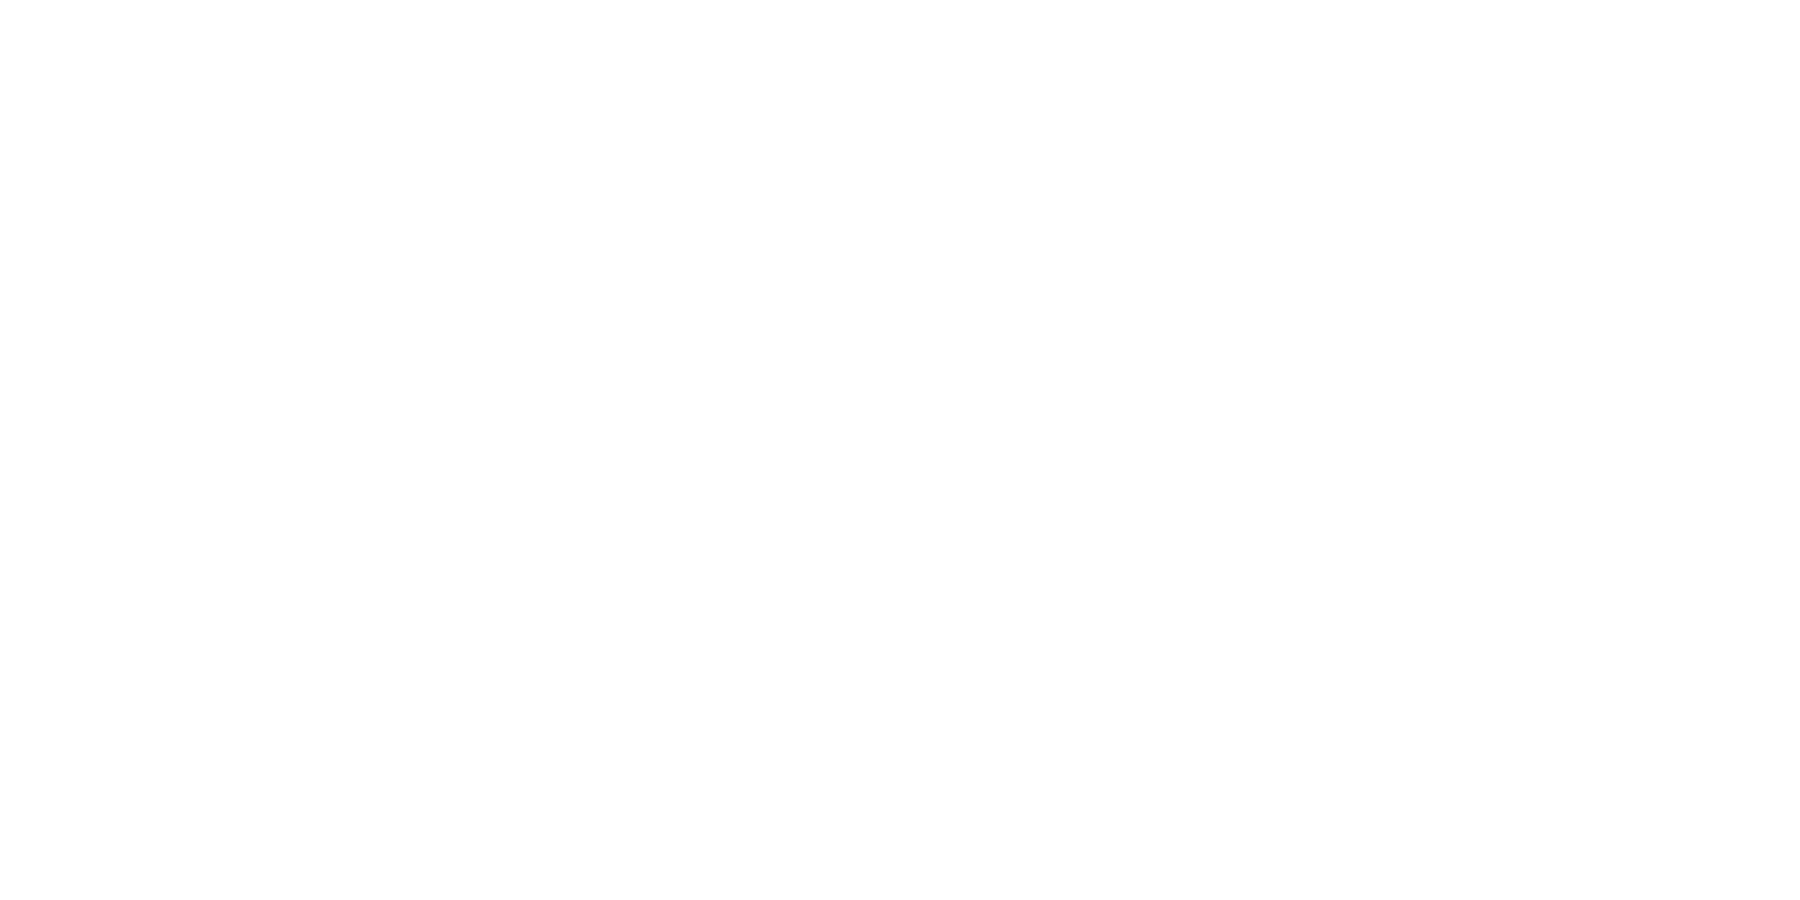

<IPython.core.display.Javascript object>


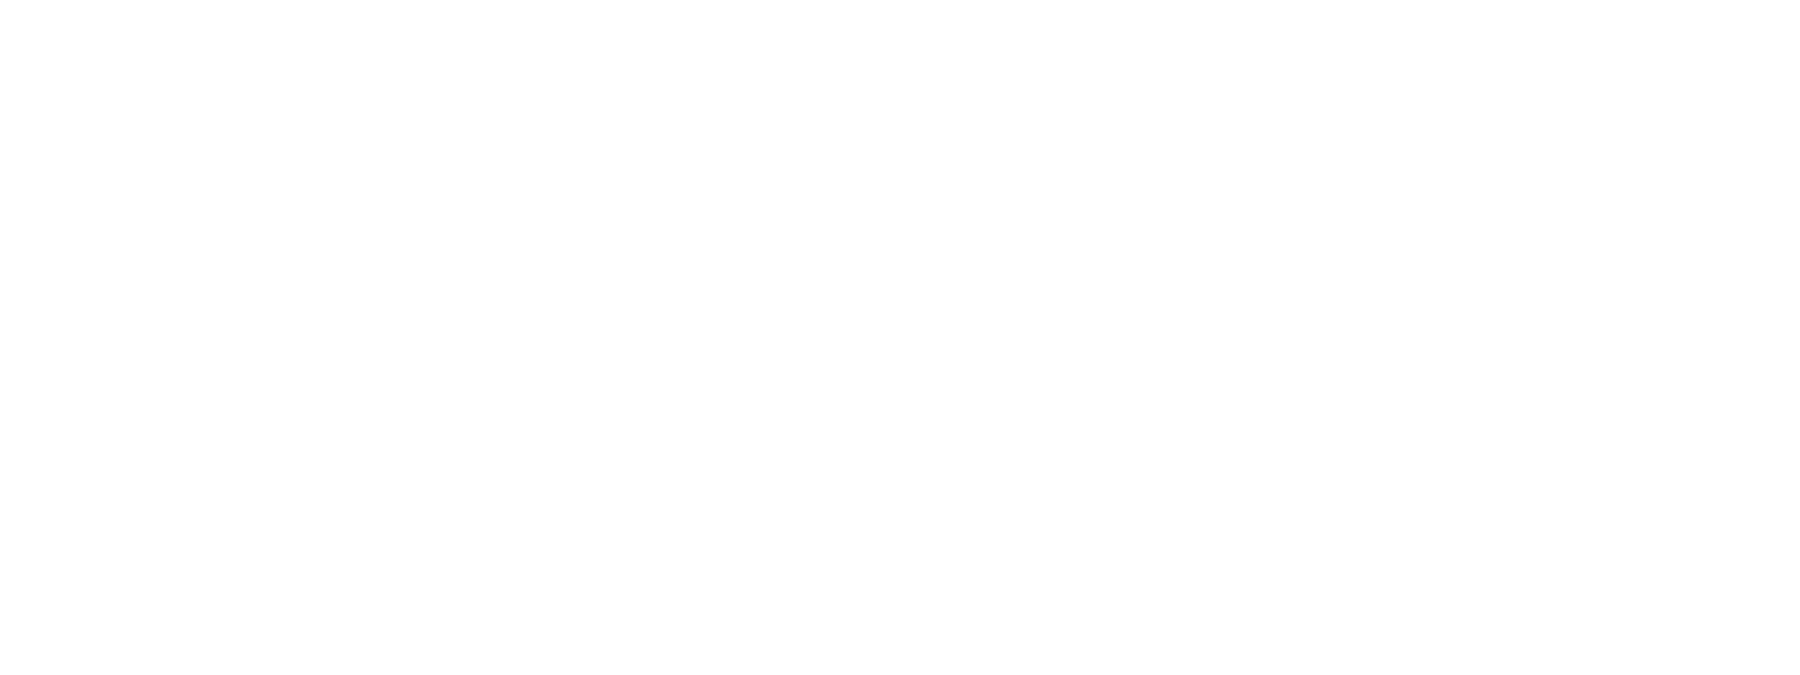

<IPython.core.display.Javascript object>


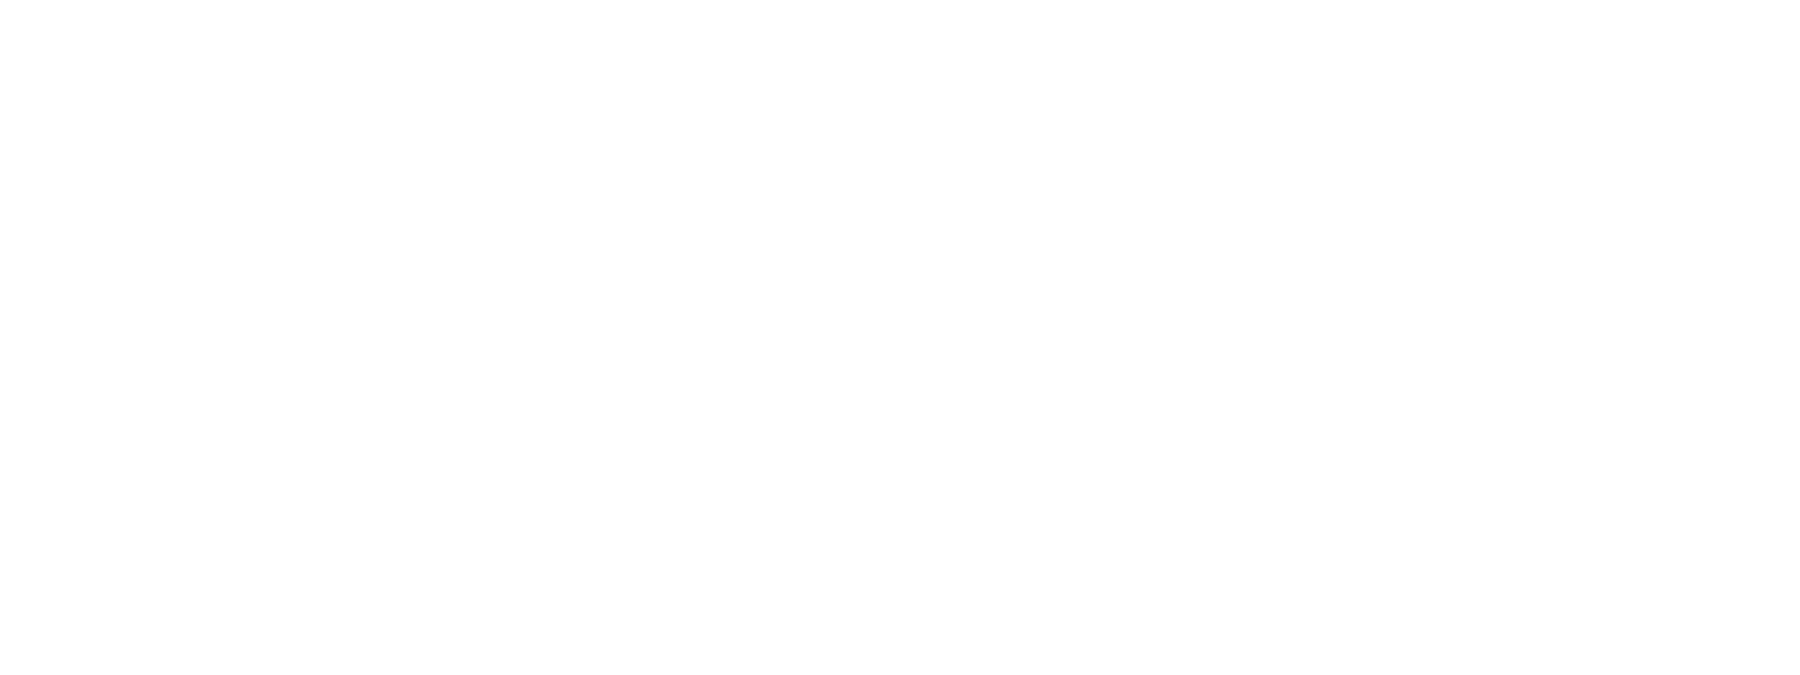

<IPython.core.display.Javascript object>


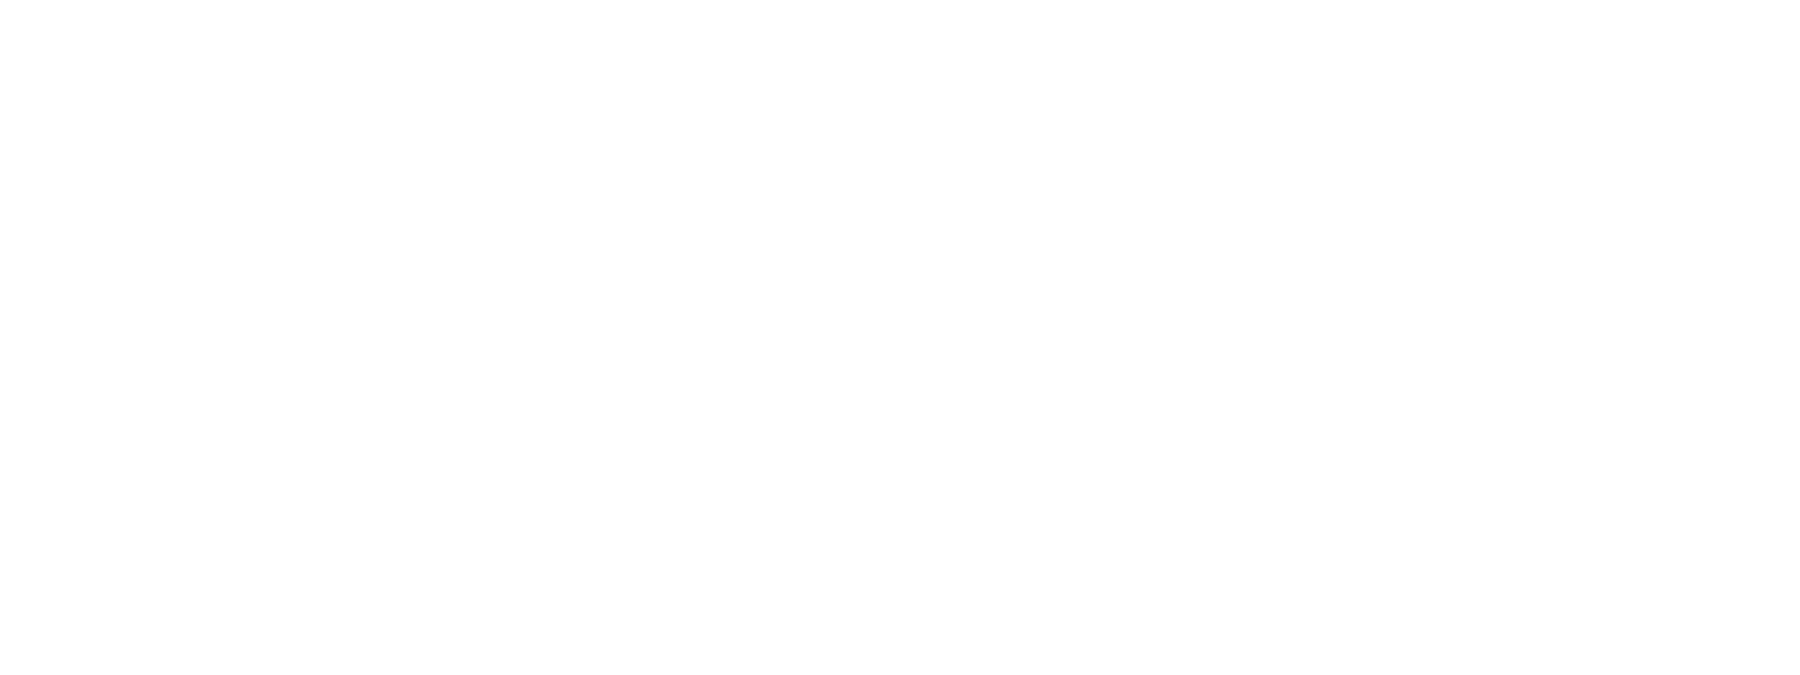

<IPython.core.display.Javascript object>


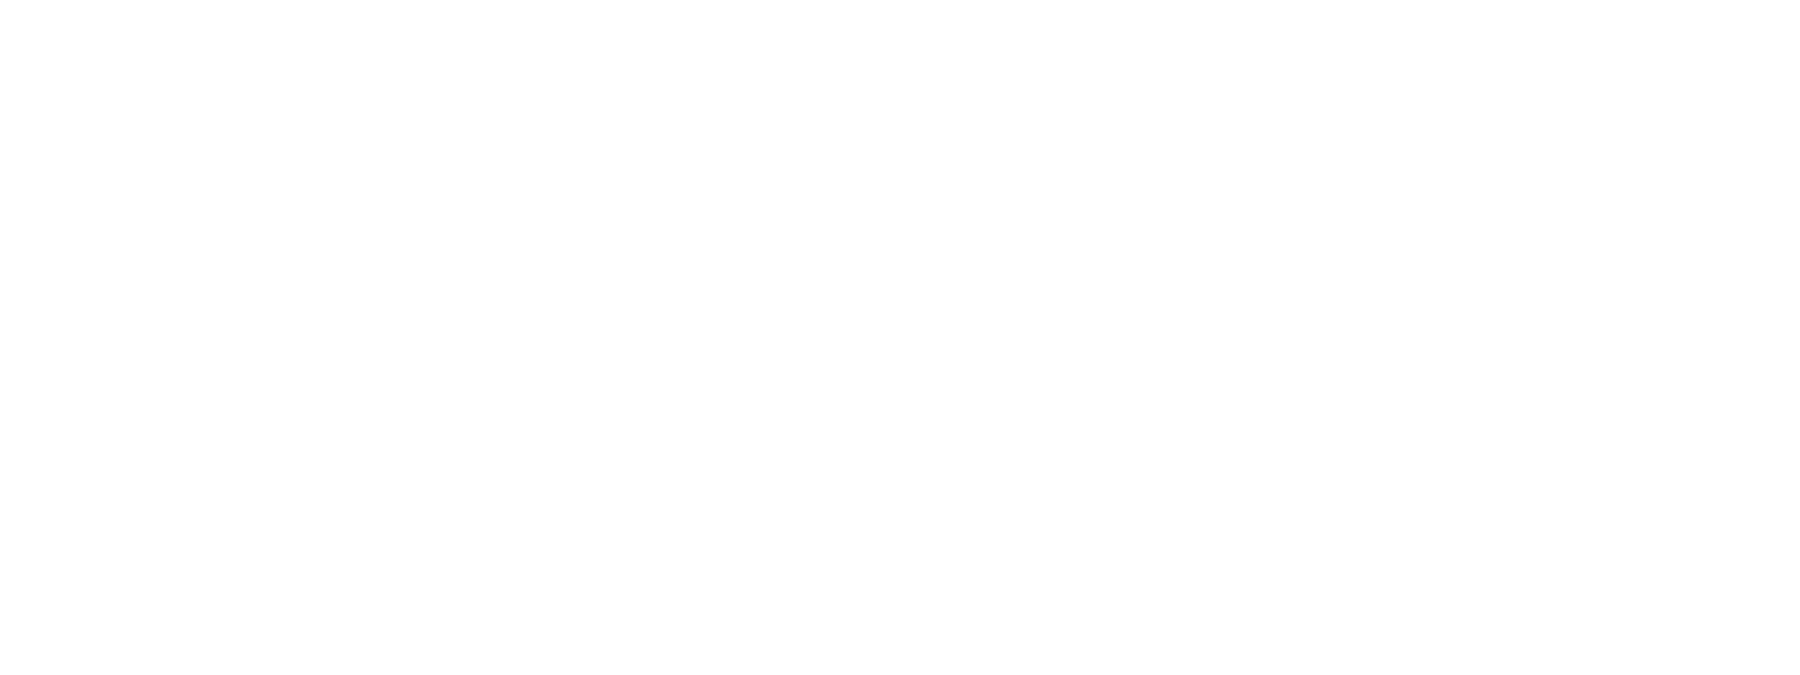

<IPython.core.display.Javascript object>


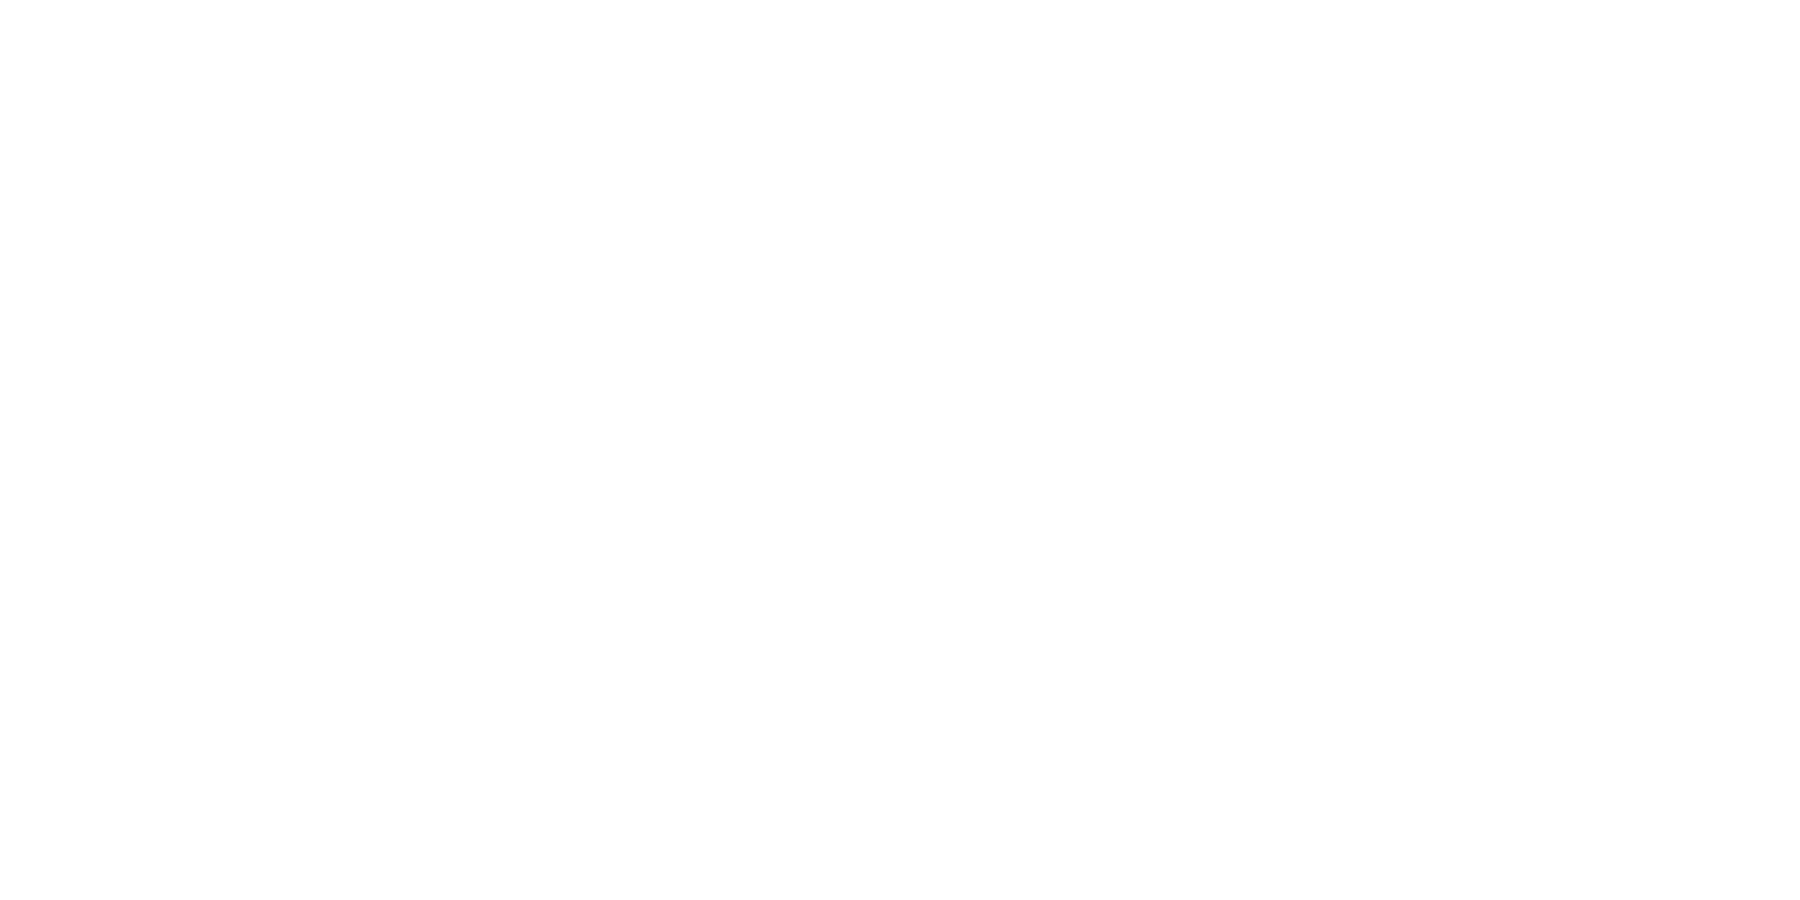

<IPython.core.display.Javascript object>


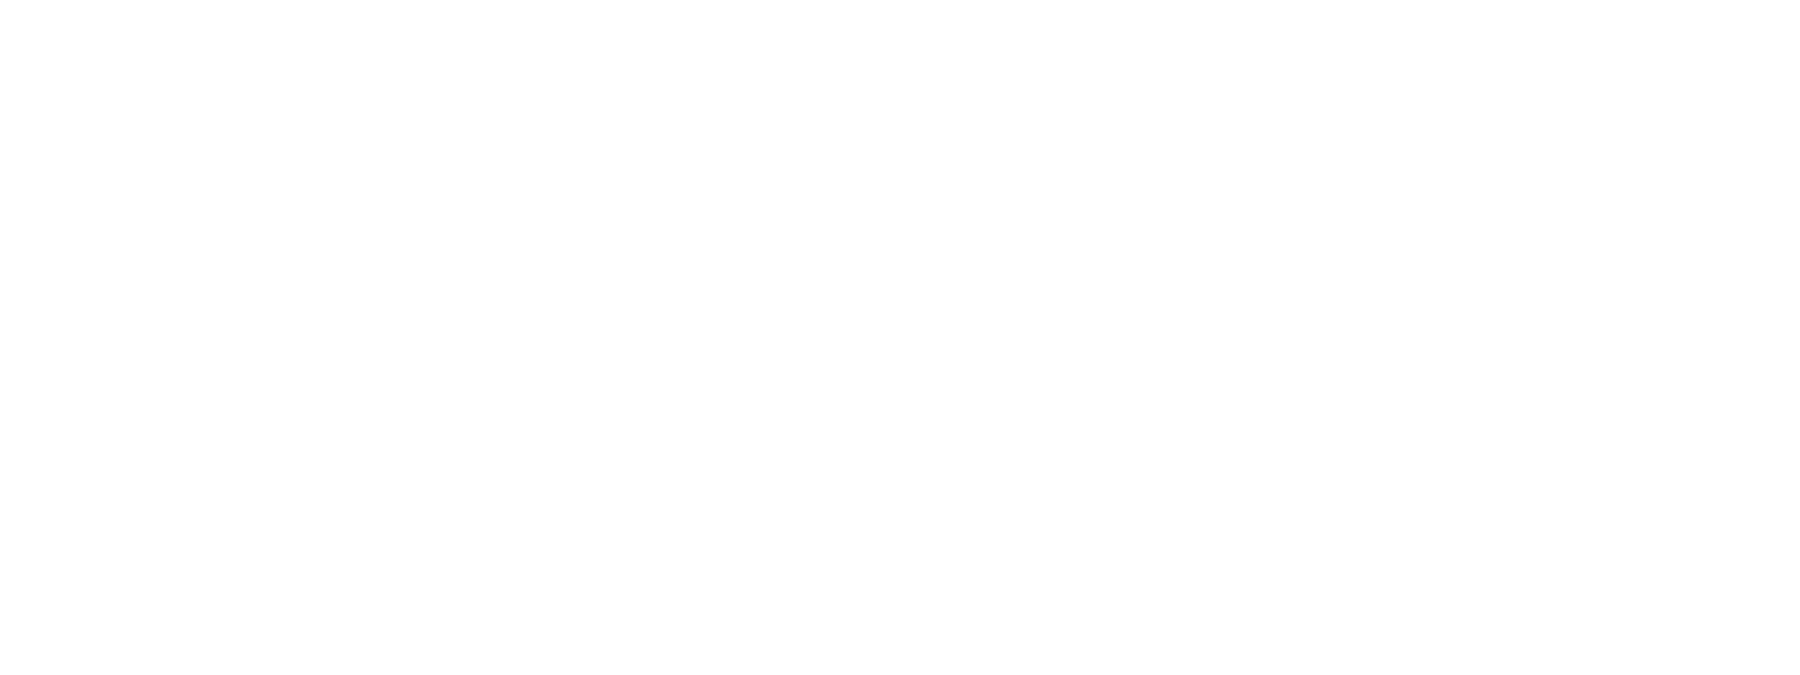

<IPython.core.display.Javascript object>


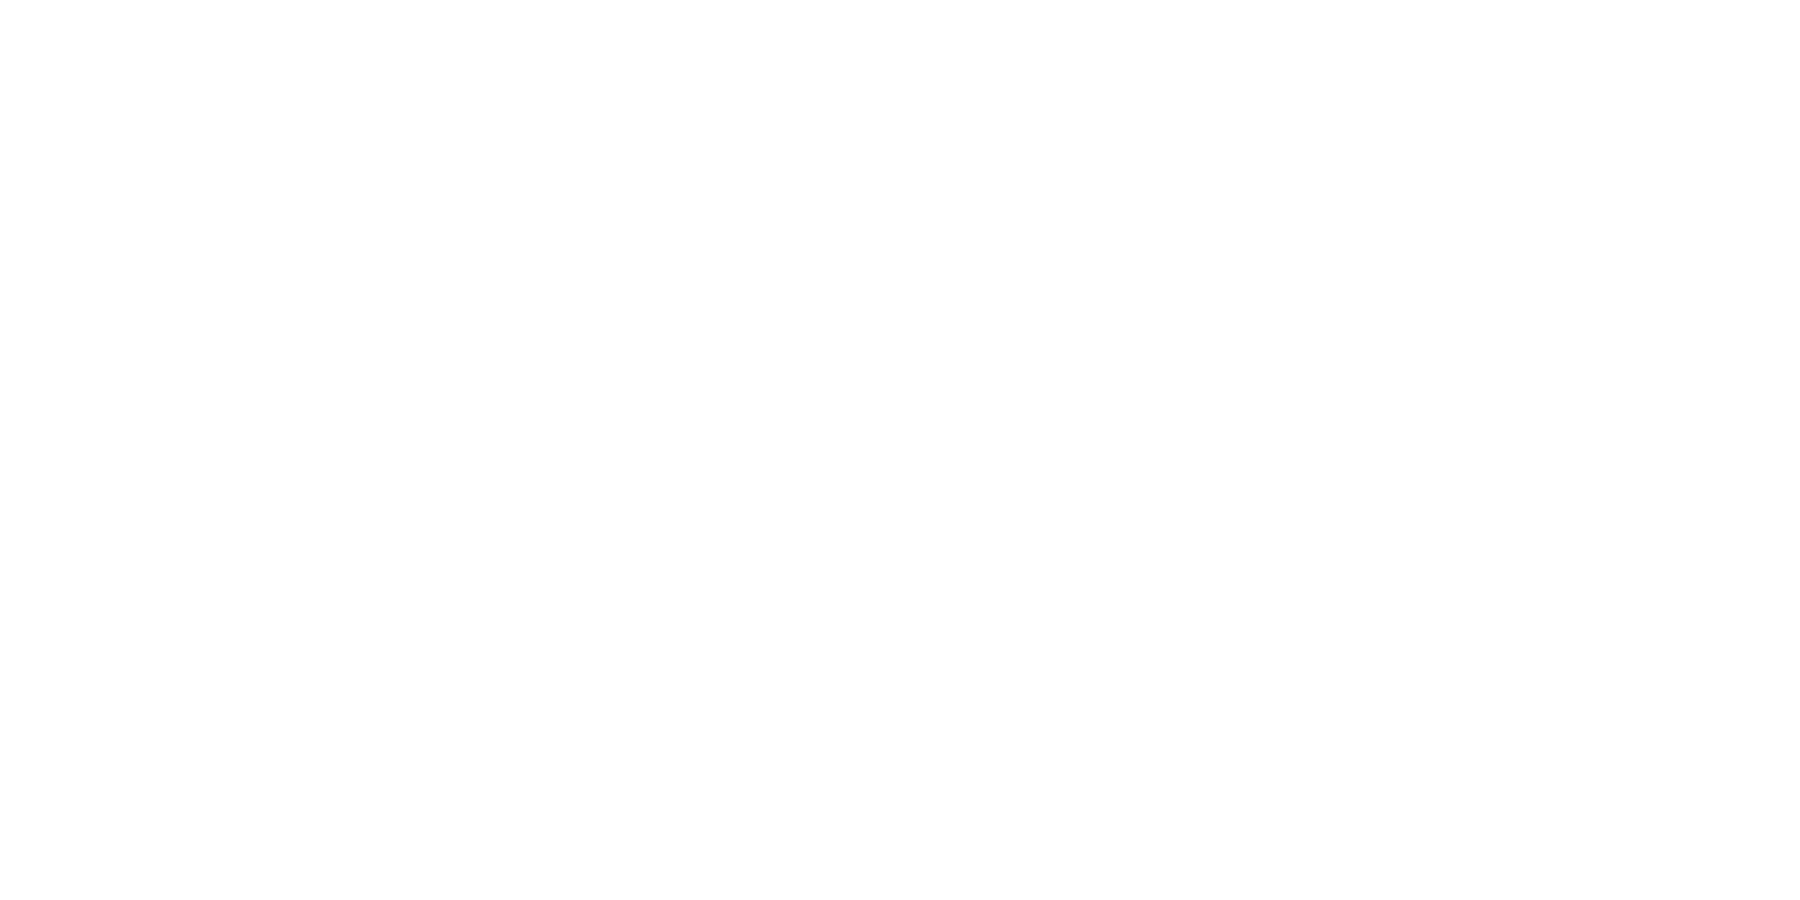

<IPython.core.display.Javascript object>


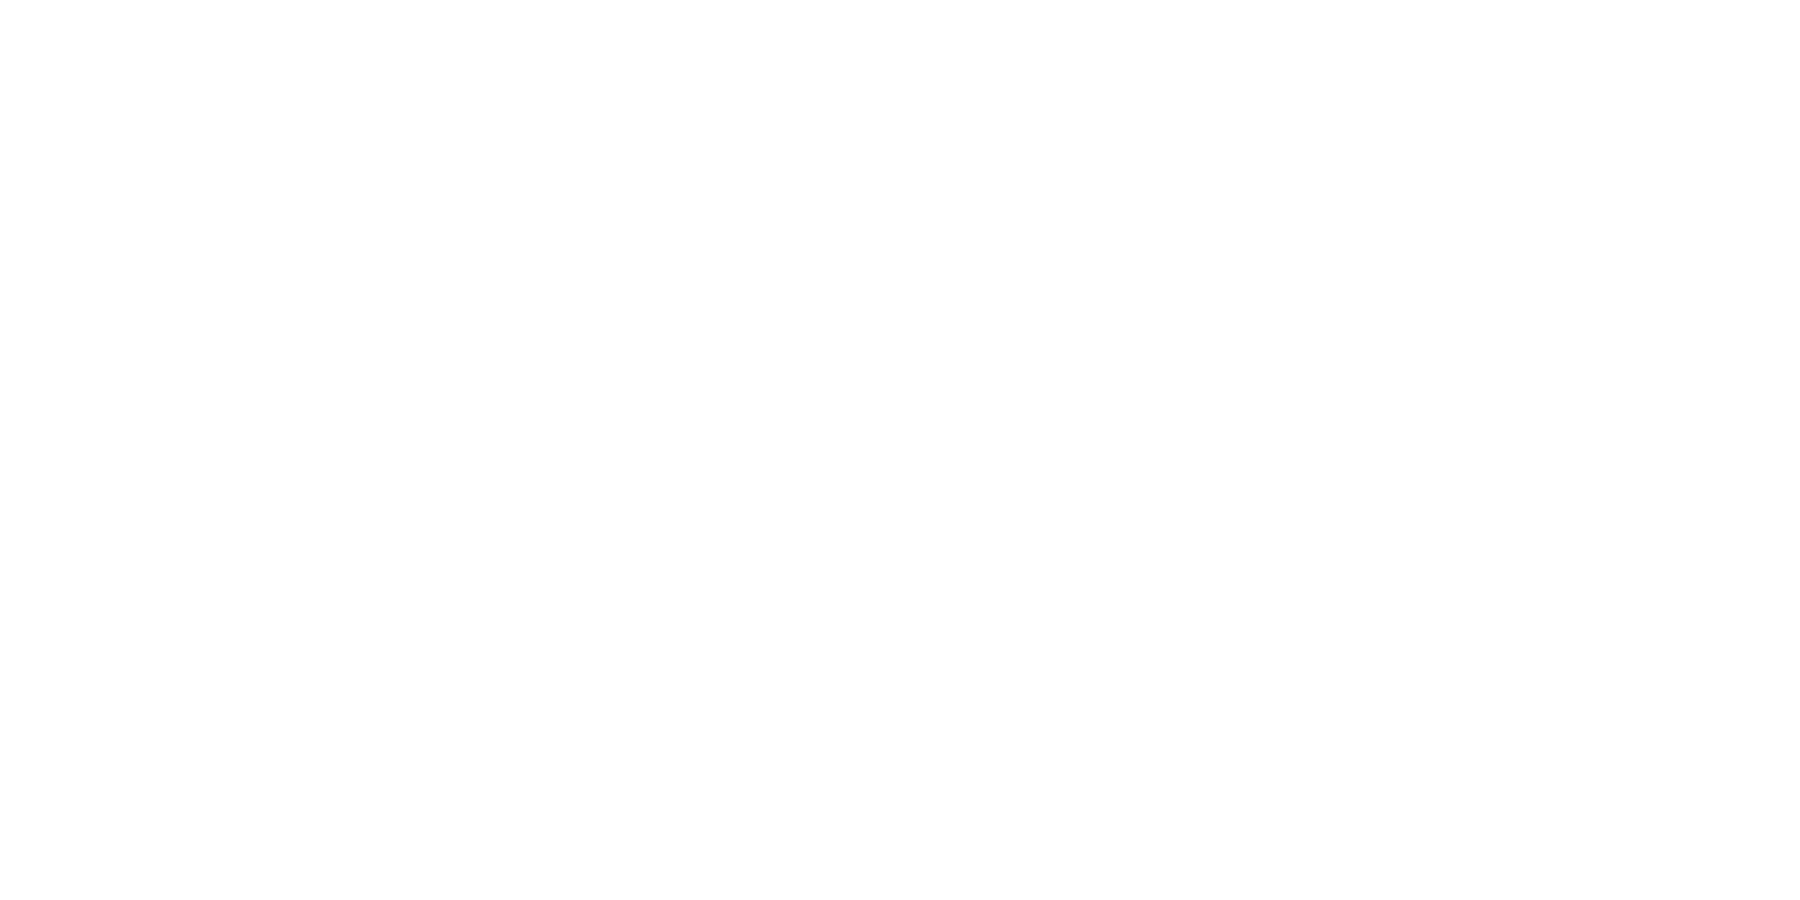

In [24]:
quantstats.reports.html(returns, output='unscaled_buylowsellhigh.html', title='BTC Sentiment')

In [25]:
cerebro.addwriter(bt.WriterFile, csv=True, out='backtrader_log_unscaled_buylowsellhigh.csv')

In [26]:
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
print('PnL: ',cerebro.broker.getvalue()-10000)
print('PnL(%): ',(cerebro.broker.getvalue()-10000)/10000*100)

Final Portfolio Value: 11199.99
PnL:  1199.9924124187673
PnL(%):  11.999924124187674
